In [1]:
from pathlib import Path


data_path = Path("ParlaMint")
if not data_path.exists():
    raise FileNotFoundError("Please run ./download_data.sh to download the data.")

exploration_language = 'TR'
exploration_path = data_path / "Samples" / f"ParlaMint-{exploration_language}"

# Load XML files from ALL countries
xml_en_files = []
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        country_code = country_dir.name.replace("ParlaMint-", "")
        xml_en_files.extend(list(country_dir.rglob("*-en_*.ana.xml")))

print(f"Found {len(xml_en_files)} XML files from all countries.")

Found 87 XML files from all countries.


In [2]:
from lxml import etree
import pandas as pd

NS = {"tei": "http://www.tei-c.org/ns/1.0"}

def parse_parlamint_xml(xml_path):
    tree = etree.parse(str(xml_path))
    root = tree.getroot()

    date_node = root.xpath("//tei:date/@when", namespaces=NS) 
    file_date = date_node[0] if date_node else "Unknown"

    data = []
    utterances = root.xpath(".//tei:u", namespaces=NS)
    
    for u in utterances:
        u_id = u.get("{http://www.w3.org/XML/1998/namespace}id")
        speaker = u.get("who")
        ana = u.get("ana", "")
        topics = [a.replace("topic:", "") for a in ana.split() if "topic:" in a]

        sentences = u.xpath(".//tei:s", namespaces=NS)
        for s in sentences:
            s_id = s.get("{http://www.w3.org/XML/1998/namespace}id")
            
            sentiment_node = s.xpath(".//tei:measure[@type='sentiment']", namespaces=NS)
            sentiment_score = float(sentiment_node[0].get("quantity")) if sentiment_node else None
            
            named_entities = s.xpath(".//tei:name/@type", namespaces=NS)
            
            tokens = []
            reconstructed_text = ""
            
            token_elements = s.xpath(".//tei:w | .//tei:pc", namespaces=NS)
            
            for i, token_el in enumerate(token_elements):
                token_text = token_el.text or ""
                
                token_data = {
                    "text": token_text,
                    "type": "word" if token_el.tag.endswith("w") else "punct",
                    "lemma": token_el.get("lemma"),
                    "pos": token_el.get("pos"),
                    "msd": token_el.get("msd"),
                    "sem": token_el.get("function")
                }
                tokens.append(token_data)
                
                reconstructed_text += token_text
                if token_el.get("join") != "right" and i < len(token_elements) - 1:
                    reconstructed_text += " "

            data.append({
                "u_id": u_id,
                "s_id": s_id,
                "speaker": speaker,
                "topics": topics,
                "sentiment": sentiment_score,
                "entities": list(set(named_entities)),
                "text": reconstructed_text,
                "tokens": tokens, 
                "date": file_date,
            })
            
    return data

all_data = []
for xml_file in xml_en_files:
    all_data.extend(parse_parlamint_xml(xml_file))

xml_df = pd.DataFrame(all_data)
print(f"Extracted {len(xml_df)} sentences from {len(xml_en_files)} XML files.")

if not xml_df.empty:
    print("\nClean Text for first sentence:")
    print(xml_df.iloc[0]['text'])
    print("\nToken metadata for first 3 tokens of first sentence:")
    print(pd.DataFrame(xml_df.iloc[0]['tokens']).head(3))


Extracted 5432 sentences from 87 XML files.

Clean Text for first sentence:
Madam President, I would like

Token metadata for first 3 tokens of first sentence:
        text   type      lemma  pos                        msd  sem
0      Madam   word      madam  NNP  UPosTag=PROPN|Number=Sing  Z1f
1  President   word  President  NNP  UPosTag=PROPN|Number=Sing  Z1f
2          ,  punct       None    Z              UPosTag=PUNCT   Z9


In [3]:
def load_taxonomy(taxonomy_path):
    tree = etree.parse(str(taxonomy_path))
    categories = tree.xpath("//tei:category", namespaces=NS)
    mapping = {}
    for cat in categories:
        cat_id = cat.get("{http://www.w3.org/XML/1998/namespace}id")
        full_desc = cat.xpath("string(./tei:catDesc)", namespaces=NS)
        if cat_id and full_desc:
            if ":" in full_desc:
                mapping[cat_id] = full_desc.split(":", 1)[-1].strip()
            else:
                mapping[cat_id] = full_desc.strip()
    return mapping

usas_tax_path = exploration_path / "ParlaMint-taxonomy-USAS.ana.xml"
usas_map = load_taxonomy(usas_tax_path)

print(f"Z5 means: {usas_map.get('Z5')}")
print(f"A1.1.1 means: {usas_map.get('A1.1.1')}")

Z5 means: Grammatical bin
A1.1.1 means: General actions / making


In [4]:
topic_tax_path = exploration_path / "ParlaMint-taxonomy-topic.xml"
topic_map = load_taxonomy(topic_tax_path)

print(f"Topic 'educa' means: {topic_map.get('educa')}")
print(f"Topic 'healt' means: {topic_map.get('healt')}")

Topic 'educa' means: Education
Topic 'healt' means: Health


In [5]:
speaker_tax_path = exploration_path / "ParlaMint-taxonomy-politicalOrientation.xml"
speaker_map = load_taxonomy(speaker_tax_path)

print(f"Speaker orientation 'orientation.C' means: {speaker_map.get('orientation.C')}")

Speaker orientation 'orientation.C' means: Centre


In [6]:
ches_tax_path = exploration_path / "ParlaMint-taxonomy-CHES.xml"
ches_map = load_taxonomy(ches_tax_path)

print(f"CHES 'ches.general' means: {ches_map.get('ches.general')}")

CHES 'ches.general' means: General indicators used to identify basic characteristics of a political party, such as country of origin, number of experts evaluating a party, membership in the EU, etc.


In [7]:
named_entity_tax_path = exploration_path / "ParlaMint-taxonomy-NER.ana.xml"
named_entity_map = load_taxonomy(named_entity_tax_path) 

print(f"Named entity 'PER' means: {named_entity_map.get('PER')}")

Named entity 'PER' means: person


In [8]:
legislature_tax_path = exploration_path / "ParlaMint-taxonomy-parla.legislature.xml"
legislature_map = load_taxonomy(legislature_tax_path)

print(f"Legislature type 'parla.organization' means: {legislature_map.get('parla.organization')}")
print(f"Legislature type 'parla.uni' means: {legislature_map.get('parla.uni')}")

Legislature type 'parla.organization' means: Organization
Legislature type 'parla.uni' means: Unicameralism


In [9]:
sentiment_tax_path = exploration_path / "ParlaMint-taxonomy-sentiment.ana.xml"
sentiment_map = load_taxonomy(sentiment_tax_path)

print(f"Sentiment 'neuneg' means: {sentiment_map.get('neuneg')}")

Sentiment 'neuneg' means: interval [1.5, 2.5)


In [10]:
speaker_type_tax_path = exploration_path / "ParlaMint-taxonomy-speaker_types.xml"
speaker_type_map = load_taxonomy(speaker_type_tax_path)

print(f"Speaker type 'chair' means: {speaker_type_map.get('chair')}")

Speaker type 'chair' means: chairman of a sitting


In [11]:
def load_person_list(person_path):
    tree = etree.parse(str(person_path))
    root = tree.getroot()
    
    persons = root.xpath("//tei:person", namespaces=NS)
    person_mapping = {}
    
    for p in persons:
        p_id = p.get("{http://www.w3.org/XML/1998/namespace}id")
        
        # Get full name
        forenames = p.xpath(".//tei:persName/tei:forename/text()", namespaces=NS)
        surname = p.xpath(".//tei:persName/tei:surname/text()", namespaces=NS)
        full_name = f"{' '.join(forenames)} {''.join(surname)}".strip()
        
        # Get sex
        sex = p.xpath("./tei:sex/@value", namespaces=NS)
        sex = sex[0] if sex else None
        
        # Get current/last party affiliation
        affiliations = p.xpath(".//tei:affiliation[contains(@ref, '#')]", namespaces=NS)
        party_ref = affiliations[-1].get("ref").replace("#", "") if affiliations else None

        # Create a list of (party_ref, start_date, end_date) tuples
        party_info = []
        for aff in affiliations:
            party_ref = aff.get("ref").replace("#", "")
            start_date = aff.get("from")
            end_date = aff.get("to")
            party_info.append((party_ref, start_date, end_date))

        person_mapping[f"#{p_id}"] = {
            "name": full_name,
            "sex": sex,
            "party": party_ref,
            "party_info": party_info
        }
        
    return person_mapping

person_path = exploration_path / "ParlaMint-TR-listPerson.xml"
speaker_info = load_person_list(person_path)

example_id = "#Abdulkadir.Akgül"
print(f"Info for {example_id}: {speaker_info.get(example_id)}")

Info for #Abdulkadir.Akgül: {'name': 'Abdulkadir Akgül', 'sex': 'M', 'party': 'party.AKP', 'party_info': [('TBMM', '2007-07-23', '2011-04-23'), ('TBMM', '2015-06-23', '2015-10-01'), ('parliamentaryGroup.AKP', '2015-06-23', '2015-10-01'), ('TBMM', '2015-11-17', '2018-05-16'), ('parliamentaryGroup.AKP', '2015-11-17', '2018-05-16'), ('party.AKP', None, None)]}


In [12]:
def load_org_list(org_path):
    tree = etree.parse(str(org_path))
    root = tree.getroot()
    
    orgs = root.xpath("//tei:org", namespaces=NS)
    org_mapping = {}
    
    for org in orgs:
        org_id = org.get("{http://www.w3.org/XML/1998/namespace}id")
        role = org.get("role")
        
        full_name = org.xpath("./tei:orgName[@full='yes']/text()", namespaces=NS)
        full_name = full_name[0] if full_name else None
        
        if not full_name:
            any_name = org.xpath("./tei:orgName/text()", namespaces=NS)
            full_name = any_name[0] if any_name else None
            
        org_mapping[org_id] = {
            "name": full_name.strip() if full_name else None,
            "role": role
        }
        
    return org_mapping

org_path = exploration_path / "ParlaMint-TR-listOrg.xml"
org_info = load_org_list(org_path)

print(f"Info for 'TBMM': {org_info.get('TBMM')}")
print(f"Info for 'party.AKP': {org_info.get('party.AKP')}")


Info for 'TBMM': {'name': 'National Assembly of the Republic of Turkey', 'role': 'parliament'}
Info for 'party.AKP': {'name': 'Adalet ve Kalkınma Partisi', 'role': 'politicalParty'}


In [13]:
def get_party_at_time(row, speaker_info):
    speaker = row['speaker'] # or 'speaker' depending on your col name
    speech_date = row['date']
    
    # Get the list of tuples for this speaker
    # party_info = [(name, from, to), (name, from, to), ...]
    speaker_data = speaker_info.get(speaker, {})
    affiliations = speaker_data.get('party_info', [])
    
    if not affiliations or affiliations == 'Unknown':
        return 'Unknown'
    
    # Iterate through affiliations to find the matching date range
    for party_name, date_from, date_to in affiliations:
        # Standardize dates for comparison (if they aren't already)
        # ParlaMint dates are usually 'YYYY-MM-DD'
        # Handle cases where date_to might be empty (still in party)
        start = date_from if date_from else '0001-01-01'
        end = date_to if date_to else '9999-12-31'
        
        if start <= speech_date <= end:
            return party_name
            
    return speaker_data.get('party', 'Unknown')

final_df = xml_df.copy()

# Initialize columns with default values
final_df['speaker_name'] = 'Unknown'
final_df['speaker_sex'] = 'Unknown'
final_df['party_id'] = 'Unknown'
final_df['party_name'] = 'Unknown'
final_df['topic_labels'] = final_df['topics'].map(lambda t_list: [topic_map.get(t, t) for t in t_list] if t_list else [])
final_df['country_code'] = 'Unknown'
final_df['source_file'] = 'Unknown'

# Map each row to its source XML file to extract country code
print("Mapping rows to source files and extracting country codes...")
xml_file_to_country = {}
for xml_file in xml_en_files:
    # Parse the XML file to get utterance IDs
    tree = etree.parse(str(xml_file))
    root = tree.getroot()
    utterances = root.xpath(".//tei:u", namespaces=NS)
    
    # Extract country code from file path
    country_code = None
    for part in str(xml_file).split('/'):
        if part.startswith('ParlaMint-'):
            country_code = part.replace('ParlaMint-', '')
            break
    
    if country_code:
        for u in utterances:
            u_id = u.get("{http://www.w3.org/XML/1998/namespace}id")
            if u_id:
                xml_file_to_country[u_id] = country_code

# Map u_id to country_code
final_df['country_code'] = final_df['u_id'].map(lambda x: xml_file_to_country.get(x, 'Unknown'))

# Enrich with country-specific speaker and organization data
print("Enriching final_df with country-specific speaker and party information...")
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        country_code = country_dir.name.replace("ParlaMint-", "")
        
        person_path = country_dir / f"ParlaMint-{country_code}-listPerson.xml"
        org_path = country_dir / f"ParlaMint-{country_code}-listOrg.xml"
        
        if not person_path.exists() or not org_path.exists():
            continue
        
        # Load country-specific data
        country_speaker_info = load_person_list(person_path)
        country_org_info = load_org_list(org_path)
        
        # Get mask for this country's rows
        country_mask = final_df['country_code'] == country_code
        
        if country_mask.sum() == 0:
            continue

        # Enrich speaker info for this country
        final_df.loc[country_mask, 'speaker_name'] = final_df.loc[country_mask, 'speaker'].map(
            lambda x: country_speaker_info.get(x, {}).get('name', 'Unknown')
        )
        final_df.loc[country_mask, 'speaker_sex'] = final_df.loc[country_mask, 'speaker'].map(
            lambda x: country_speaker_info.get(x, {}).get('sex', 'Unknown')
        )
        final_df.loc[country_mask, 'party_id'] = final_df[country_mask].apply(
            lambda row: get_party_at_time(row, country_speaker_info), axis=1
        )
        final_df.loc[country_mask, 'party_name'] = final_df.loc[country_mask, 'party_id'].map(
            lambda x: country_org_info.get(x, {}).get('name', 'Unknown')
        )



# Display results, include also speech date
columns_to_show = [
    's_id', 'country_code', 'speaker_name', 'speaker_sex', 'party_id', 'party_name',
    'sentiment', 'topic_labels', 'text', 'date'
]

print(f"Final dataset built with {len(final_df)} rows and {len(final_df.columns)} columns.")
print(f"Countries represented: {final_df['country_code'].unique()}")
print(f"Country distribution:\n{final_df['country_code'].value_counts()}")
final_df[columns_to_show].head(50)

Mapping rows to source files and extracting country codes...
Enriching final_df with country-specific speaker and party information...
Final dataset built with 5432 rows and 16 columns.
Countries represented: ['SE' 'UA' 'PL' 'BE' 'GR' 'NO' 'EE' 'LV' 'CZ' 'IS' 'IT' 'RS' 'SI' 'PT'
 'ES-GA' 'GB' 'BA' 'ES-PV' 'AT' 'DK' 'BG' 'HU' 'NL' 'HR' 'FR' 'ES' 'FI'
 'ES-CT' 'TR']
Country distribution:
country_code
CZ       644
SE       602
TR       433
UA       365
RS       289
HU       274
IS       266
ES-CT    256
GB       198
BG       192
PL       177
BA       154
ES-PV    138
SI       137
GR       127
EE       115
FR       113
LV       110
BE       100
DK        99
HR        97
NL        94
ES-GA     75
PT        71
IT        69
FI        67
AT        65
NO        57
ES        48
Name: count, dtype: int64


,s_id,country_code,speaker_name,speaker_sex,party_id,party_name,sentiment,topic_labels,text,date
0,i-7Gocwwgm1SAsUELPMWzXuE,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,4.017,[Mix],"Madam President, I would like",2025-06-23
1,i-7GodASKwaGTGUA8Kq8nQCL,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,2.313,[Mix],Anders Åkesson has asked me when and in what w...,2025-06-23
2,i-7GodHw7T7ZphsKCgv74KaC,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,2.331,[Mix],The County Administrative Board of Kalmar Coun...,2025-06-23
3,i-7GodPmH4ygtVQDNXYCAFye,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,0.572,[Mix],The proposals are aimed at removing the protec...,2025-06-23
4,i-7GodVbSgqoxGw7YNAHGCP6,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,1.452,[Mix],As the matter is still being prepared in the G...,2025-06-23
5,i-7GodbRcJhw24U1iCnNN8nY,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,2.786,[Mix],Anders Åkesson also addresses the emerging sit...,2025-06-23
6,i-7Godi65sQeEfw3LJdu44gC,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,0.626,[Mix],I share Anders Åkesson's concern about the sit...,2025-06-23
7,i-7GodovFVGmJTTwW9FzA15e,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,0.981,[Mix],The Government is therefore now proposing a cr...,2025-06-23
8,i-7GodukR78tNEzqfyt5FwV6,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,3.137,[Mix],The package is based on an agreement between t...,2025-06-23
9,i-7Goe1aaj11S2XjqpWAMstY,SE,Annika Strandhäll,F,Q105112,Socialdemokraterna,3.544,[Mix],With these proposals and the measures previous...,2025-06-23


## Dataset Overview
Basic Statistics

- Number of speeches/documents
- Speech length distribution (word counts)
- Date range coverage
- Number of speakers and organizations

In [14]:
# Number of speeches per country
country_speech_counts = {}
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        country_code = country_dir.name.replace("ParlaMint-", "")
        xml_files = list(country_dir.rglob("*-en_*.ana.xml"))
        total_speeches = 0
        for xml_file in xml_files:
            tree = etree.parse(str(xml_file))
            root = tree.getroot()
            utterances = root.xpath(".//tei:u", namespaces=NS)
            total_speeches += len(utterances)
        country_speech_counts[country_code] = total_speeches

print("Number of speeches per country:")
for country, count in country_speech_counts.items():
    print(f"{country}: {count} speeches")


Number of speeches per country:
SE: 12 speeches
UA: 12 speeches
PL: 12 speeches
BE: 12 speeches
GR: 12 speeches
NO: 12 speeches
EE: 12 speeches
LV: 12 speeches
CZ: 12 speeches
IS: 12 speeches
IT: 12 speeches
RS: 12 speeches
SI: 12 speeches
PT: 12 speeches
ES-GA: 12 speeches
GB: 12 speeches
BA: 12 speeches
ES-PV: 12 speeches
DE: 0 speeches
AT: 8 speeches
DK: 12 speeches
BG: 12 speeches
HU: 12 speeches
NL: 12 speeches
HR: 12 speeches
FR: 12 speeches
ES: 12 speeches
FI: 12 speeches
IL: 0 speeches
ES-CT: 12 speeches
TR: 9 speeches
ES-CN: 0 speeches


As we decided to use only the dataset machine translated to English, we will discard DE, IL, ES-CN and CN.

In [15]:
# Create a list with DE, IL, ES-CN, CN

selected_countries = ['DE', 'IL', 'ES-CN', 'CN']
print(final_df.shape)

# Remove the selected countries from final_df
filtered_df = final_df[~final_df['s_id'].str.contains('|'.join(selected_countries))]
print(filtered_df.shape)

(5432, 16)
(5428, 16)


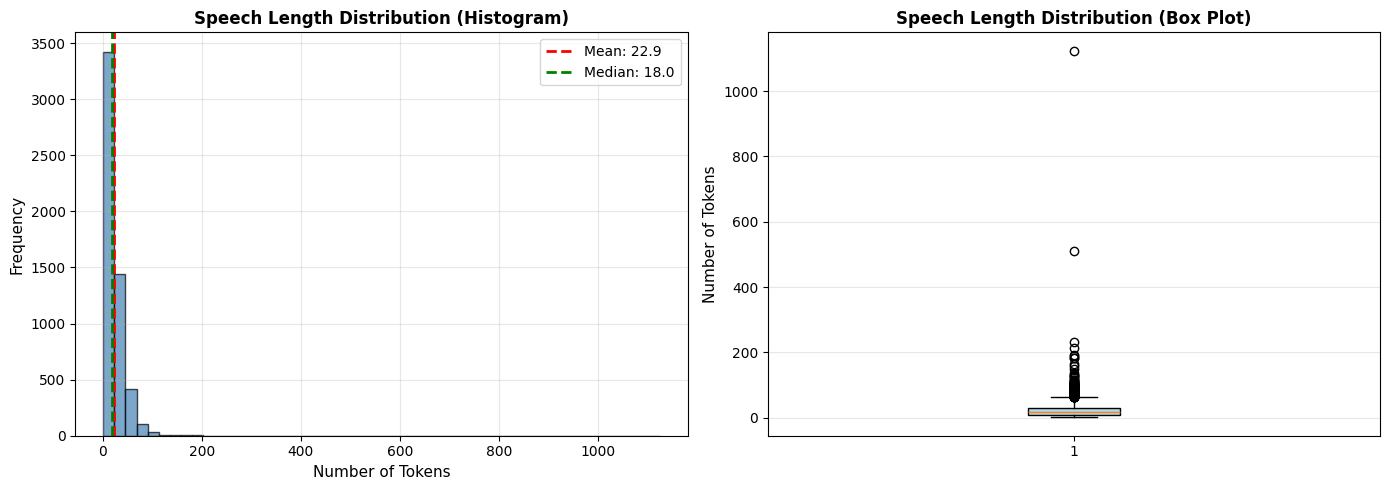

Speech Length Statistics:
  Count:  5432
  Mean:   22.85
  Median: 18.00
  Std:    25.24
  Min:    1
  Max:    1124
  25th percentile: 9
  75th percentile: 30


In [16]:
# Speech length distribution
import matplotlib.pyplot as plt

final_df['speech_length'] = final_df['tokens'].map(len)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with statistics
ax1 = axes[0]
ax1.hist(final_df['speech_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')

# Add statistical lines
mean_len = final_df['speech_length'].mean()
median_len = final_df['speech_length'].median()
ax1.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_len:.1f}')
ax1.axvline(median_len, color='green', linestyle='--', linewidth=2, label=f'Median: {median_len:.1f}')

ax1.set_title('Speech Length Distribution (Histogram)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Tokens', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(final_df['speech_length'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax2.set_title('Speech Length Distribution (Box Plot)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Tokens', fontsize=11)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Speech Length Statistics:")
print(f"  Count:  {len(final_df)}")
print(f"  Mean:   {mean_len:.2f}")
print(f"  Median: {median_len:.2f}")
print(f"  Std:    {final_df['speech_length'].std():.2f}")
print(f"  Min:    {final_df['speech_length'].min()}")
print(f"  Max:    {final_df['speech_length'].max()}")
print(f"  25th percentile: {final_df['speech_length'].quantile(0.25):.0f}")
print(f"  75th percentile: {final_df['speech_length'].quantile(0.75):.0f}")

In [17]:
# Data range coverage
date_ranges = {}
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        # If the country is in selected_countries, skip it
        if country_dir.name.replace("ParlaMint-", "") in selected_countries:
            continue
        country_code = country_dir.name.replace("ParlaMint-", "")
        xml_files = list(country_dir.rglob("*-en_*.ana.xml"))
        min_date, max_date = None, None
        for xml_file in xml_files:
            tree = etree.parse(str(xml_file))
            root = tree.getroot()
            dates = root.xpath("//tei:date/@when", namespaces=NS)
            for date_str in dates:
                if min_date is None or date_str < min_date:
                    min_date = date_str
                if max_date is None or date_str > max_date:
                    max_date = date_str
        date_ranges[country_code] = (min_date, max_date)

print("Data range coverage per country:")
for country, (start_date, end_date) in date_ranges.items():
    print(f"{country}: from {start_date} to {end_date}")

Data range coverage per country:
SE: from 2017-12-12 to 2025-06-23
UA: from 2008-09-30 to 2025-06-23
PL: from 2017-07-20 to 2025-06-23
BE: from 2017-04-27 to 2025-06-23
GR: from 2017-06-09 to 2025-06-23
NO: from 2004-06-08 to 2025-06-23
EE: from 2014-12-02 to 2025-06-23
LV: from 2019-01-31 to 2025-06-23
CZ: from 2016-10-27 to 2025-06-23
IS: from 2017-03-20 to 2025-06-30
IT: from 2015-06-10 to 2025-06-23
RS: from 2008-07-18 to 2025-06-25
SI: from 2007-11-28 to 2025-06-23
PT: from 2017-11-29 to 2025-06-23
ES-GA: from 2017-05-24 to 2025-06-23
GB: from 2017-09-07 to 2025-06-23
BA: from 2006-07-07 to 2025-06-24
ES-PV: from 2017-10-05 to 2025-06-23
AT: from 2005-04-27 to 2025-06-24
DK: from 2017-05-18 to 2025-06-23
BG: from 2017-05-11 to 2025-06-23
HU: from 2016-12-07 to 2025-06-23
NL: from 2017-01-26 to 2025-06-23
HR: from 2011-05-05 to 2025-06-25
FR: from 2019-01-16 to 2025-06-23
ES: from 2017-11-28 to 2025-06-23
FI: from 2017-10-04 to 2025-06-23
ES-CT: from 2018-05-04 to 2025-06-23
TR: fr

In [18]:
# Number of speakers and organizations per country
country_speaker_org_counts = {}
for country_dir in (data_path / "Samples").iterdir():
    if country_dir.is_dir():
        # If the country is in selected_countries, skip it
        if country_dir.name.replace("ParlaMint-", "") in selected_countries:
            continue
        country_code = country_dir.name.replace("ParlaMint-", "")
        
        person_path = country_dir / f"ParlaMint-{country_code}-listPerson.xml"
        org_path = country_dir / f"ParlaMint-{country_code}-listOrg.xml"
        
        speaker_info = load_person_list(person_path)
        org_info = load_org_list(org_path)
        
        num_speakers = len(speaker_info)
        num_orgs = len(org_info)
        
        country_speaker_org_counts[country_code] = (num_speakers, num_orgs)

print("Number of speakers and organizations per country:")
for country, (num_speakers, num_orgs) in country_speaker_org_counts.items():
    print(f"{country}: {num_speakers} speakers, {num_orgs} organizations")  

Number of speakers and organizations per country:
SE: 649 speakers, 15 organizations
UA: 2617 speakers, 151 organizations
PL: 1223 speakers, 12 organizations
BE: 786 speakers, 68 organizations
GR: 635 speakers, 16 organizations
NO: 1106 speakers, 17 organizations
EE: 488 speakers, 8 organizations
LV: 234 speakers, 13 organizations
CZ: 597 speakers, 450 organizations
IS: 261 speakers, 12 organizations
IT: 771 speakers, 47 organizations
RS: 1724 speakers, 73 organizations
SI: 973 speakers, 32 organizations
PT: 836 speakers, 25 organizations
ES-GA: 227 speakers, 59 organizations
GB: 1951 speakers, 37 organizations
BA: 603 speakers, 42 organizations
ES-PV: 197 speakers, 11 organizations
AT: 854 speakers, 37 organizations
DK: 383 speakers, 21 organizations
BG: 1032 speakers, 46 organizations
HU: 492 speakers, 94 organizations
NL: 586 speakers, 50 organizations
HR: 1036 speakers, 47 organizations
FR: 908 speakers, 185 organizations
ES: 941 speakers, 52 organizations
FI: 314 speakers, 19 orga

## Gouvernment vs Opposition Anlaysis

- compare speech frequencies, lengths, sentiment between gouvernment and opposition
- identify patterns in who speaks more/longer


Processing AT with temporal matching...


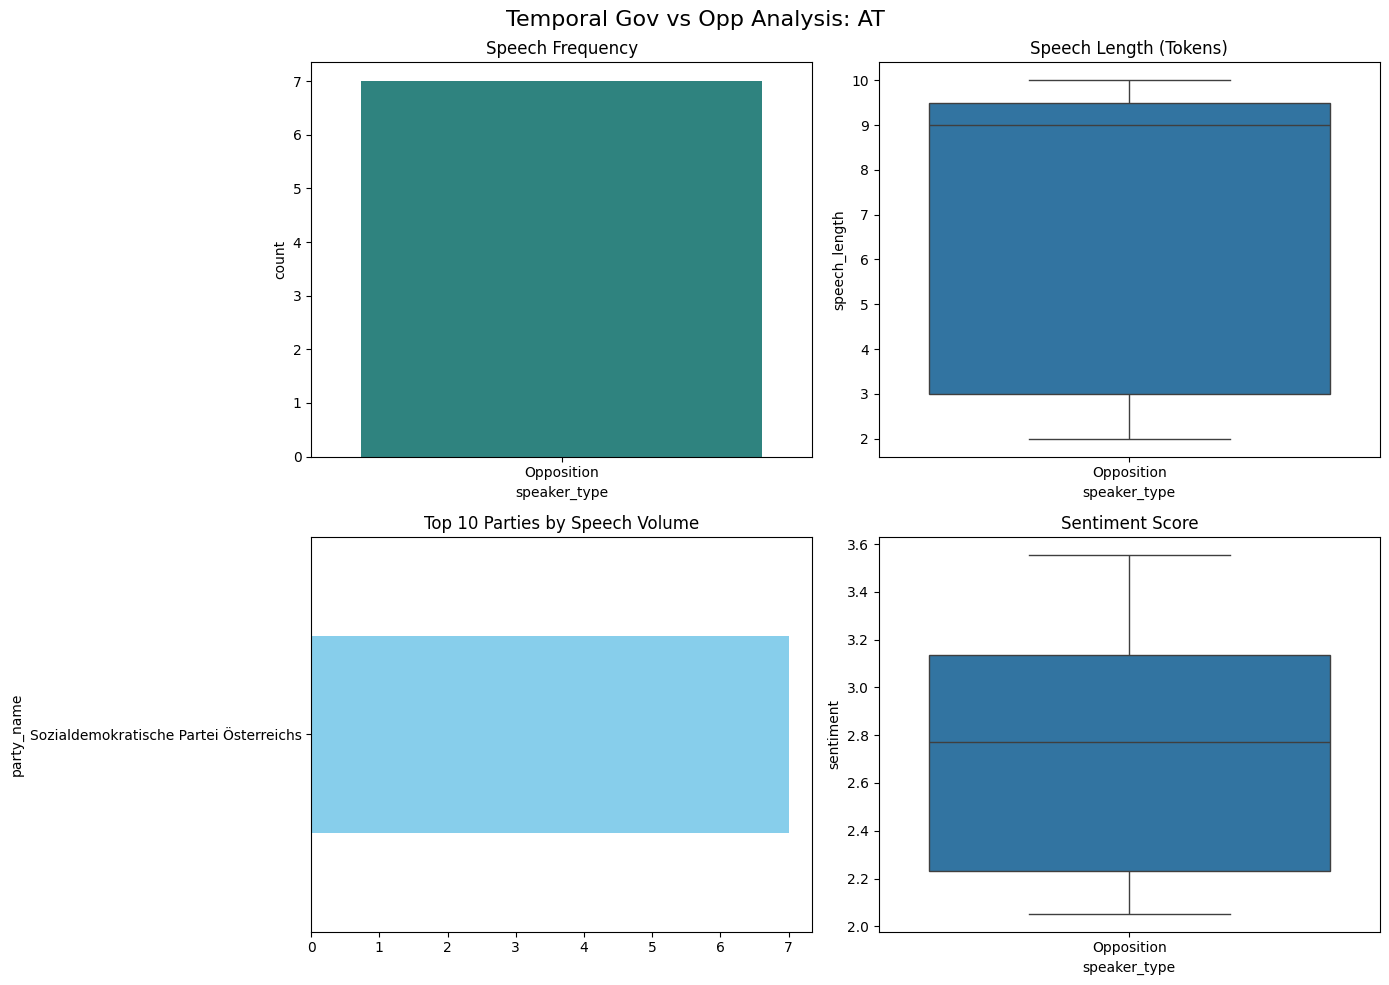


Processing BA with temporal matching...
Skipping BA: Not enough temporal matches found.
Total speeches after filtering: 0

Processing BE with temporal matching...


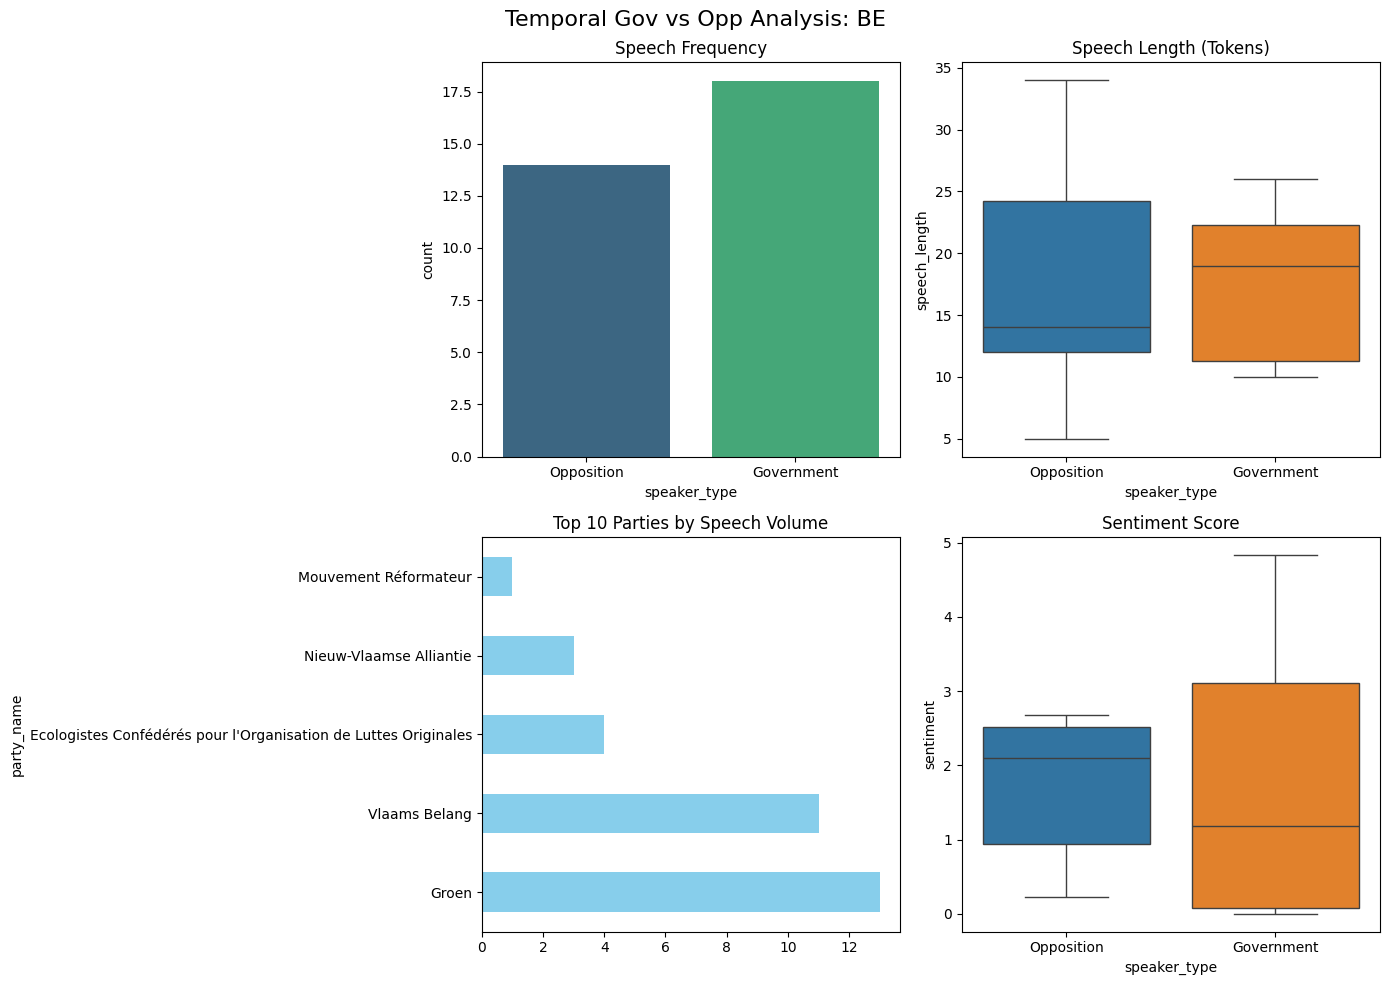


Processing BG with temporal matching...
Skipping BG: Not enough temporal matches found.
Total speeches after filtering: 0

Processing CZ with temporal matching...
Skipping CZ: Not enough temporal matches found.
Total speeches after filtering: 0

Processing DK with temporal matching...


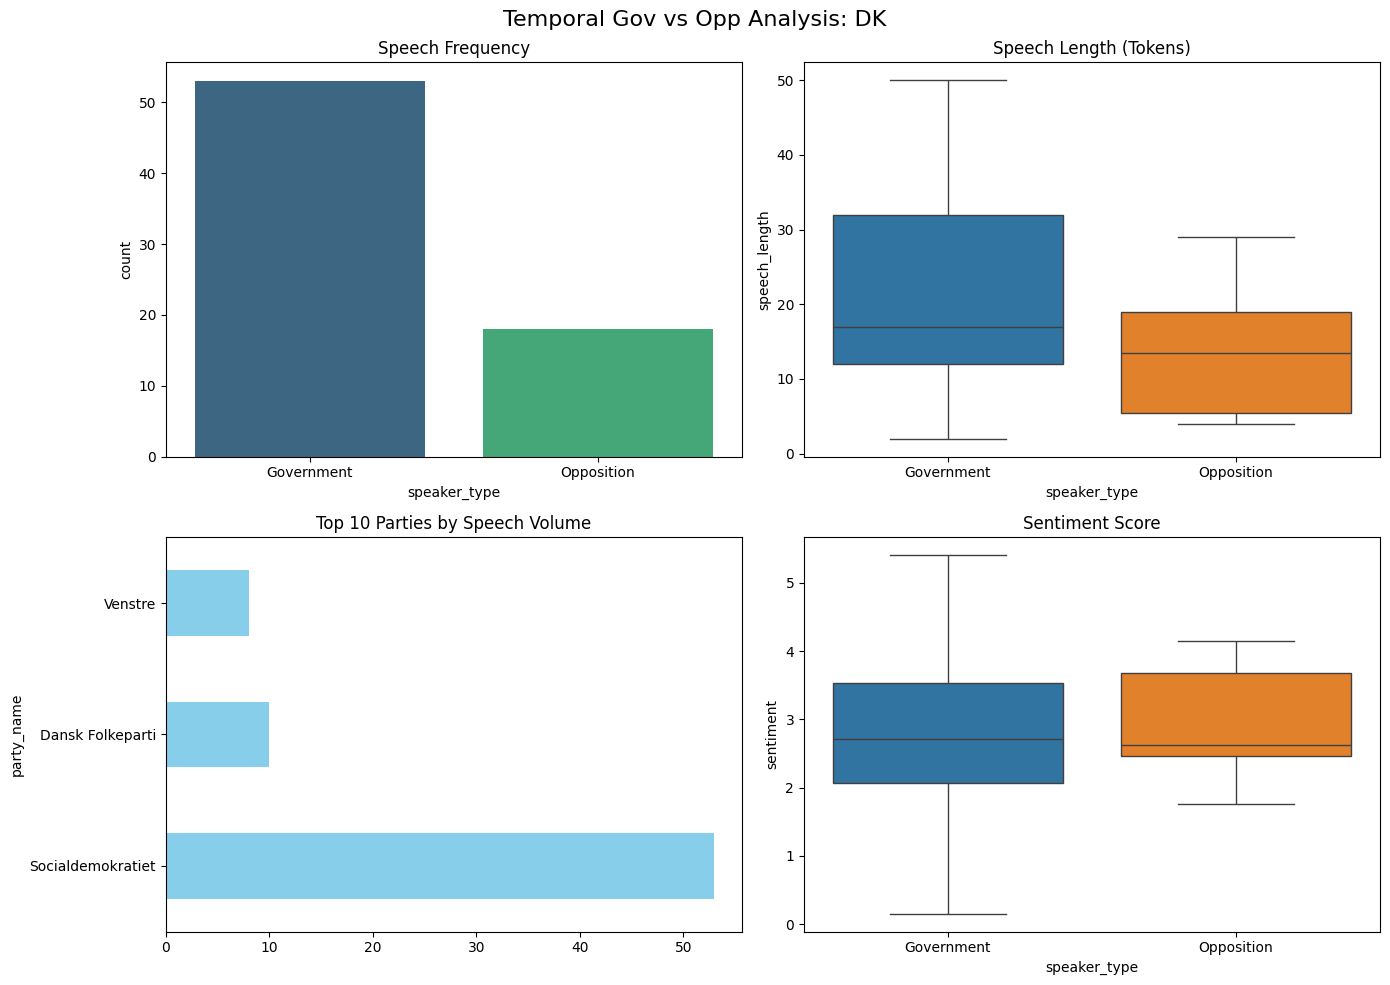


Processing EE with temporal matching...
Skipping EE: Not enough temporal matches found.
Total speeches after filtering: 0

Processing ES with temporal matching...
Skipping ES: Not enough temporal matches found.
Total speeches after filtering: 4

Processing ES-CT with temporal matching...
Skipping ES-CT: Not enough temporal matches found.
Total speeches after filtering: 0

Processing ES-GA with temporal matching...
Skipping ES-GA: Not enough temporal matches found.
Total speeches after filtering: 0

Processing ES-PV with temporal matching...
Skipping ES-PV: Not enough temporal matches found.
Total speeches after filtering: 0

Processing FI with temporal matching...


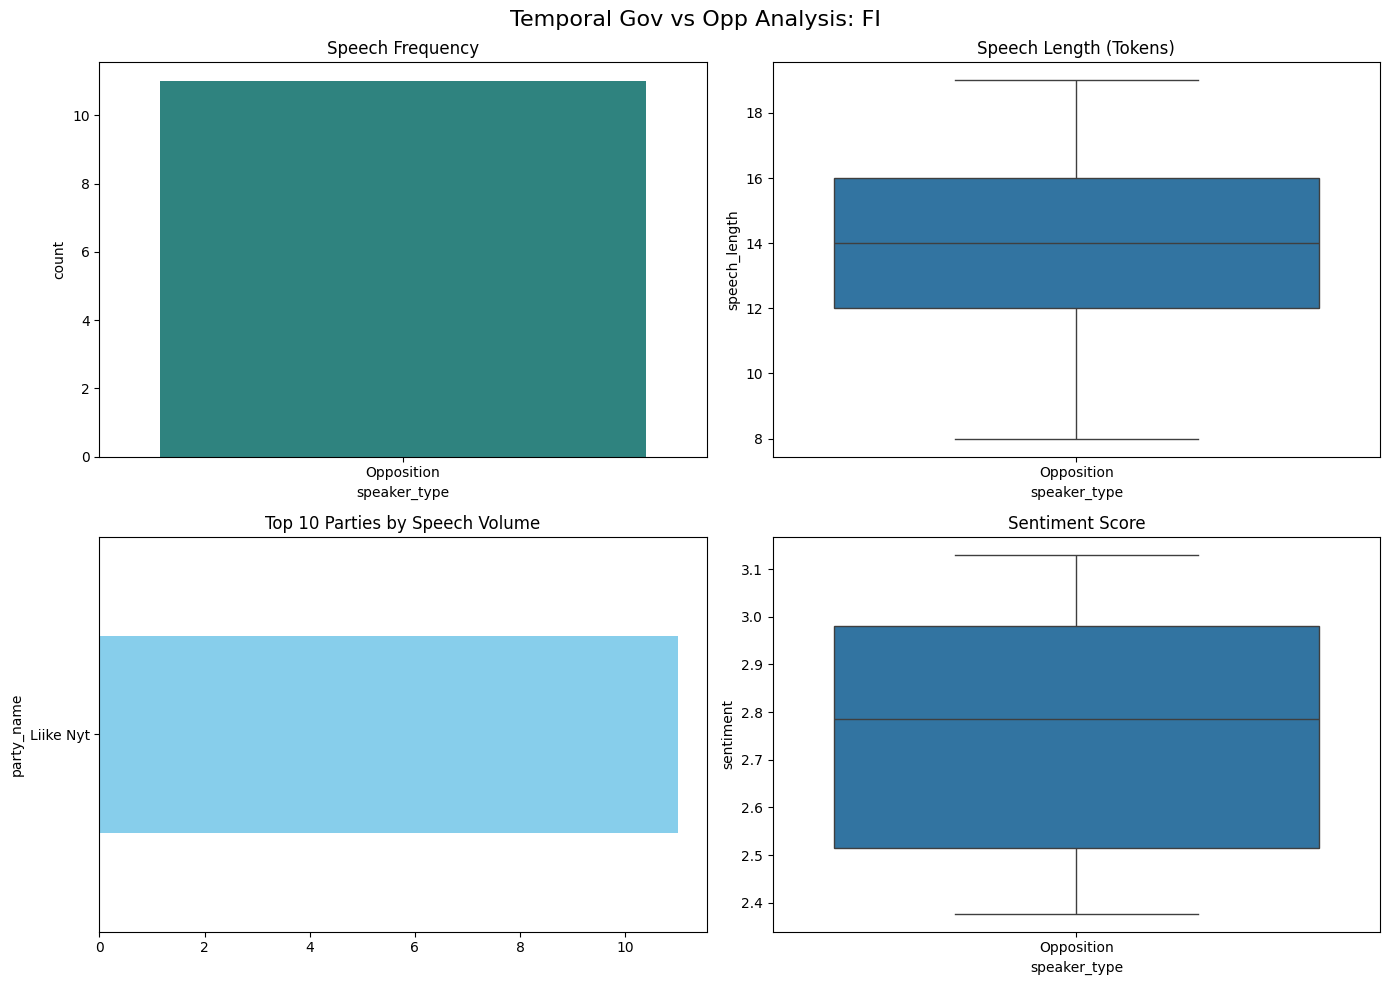


Processing FR with temporal matching...
Skipping FR: Not enough temporal matches found.
Total speeches after filtering: 0

Processing GB with temporal matching...


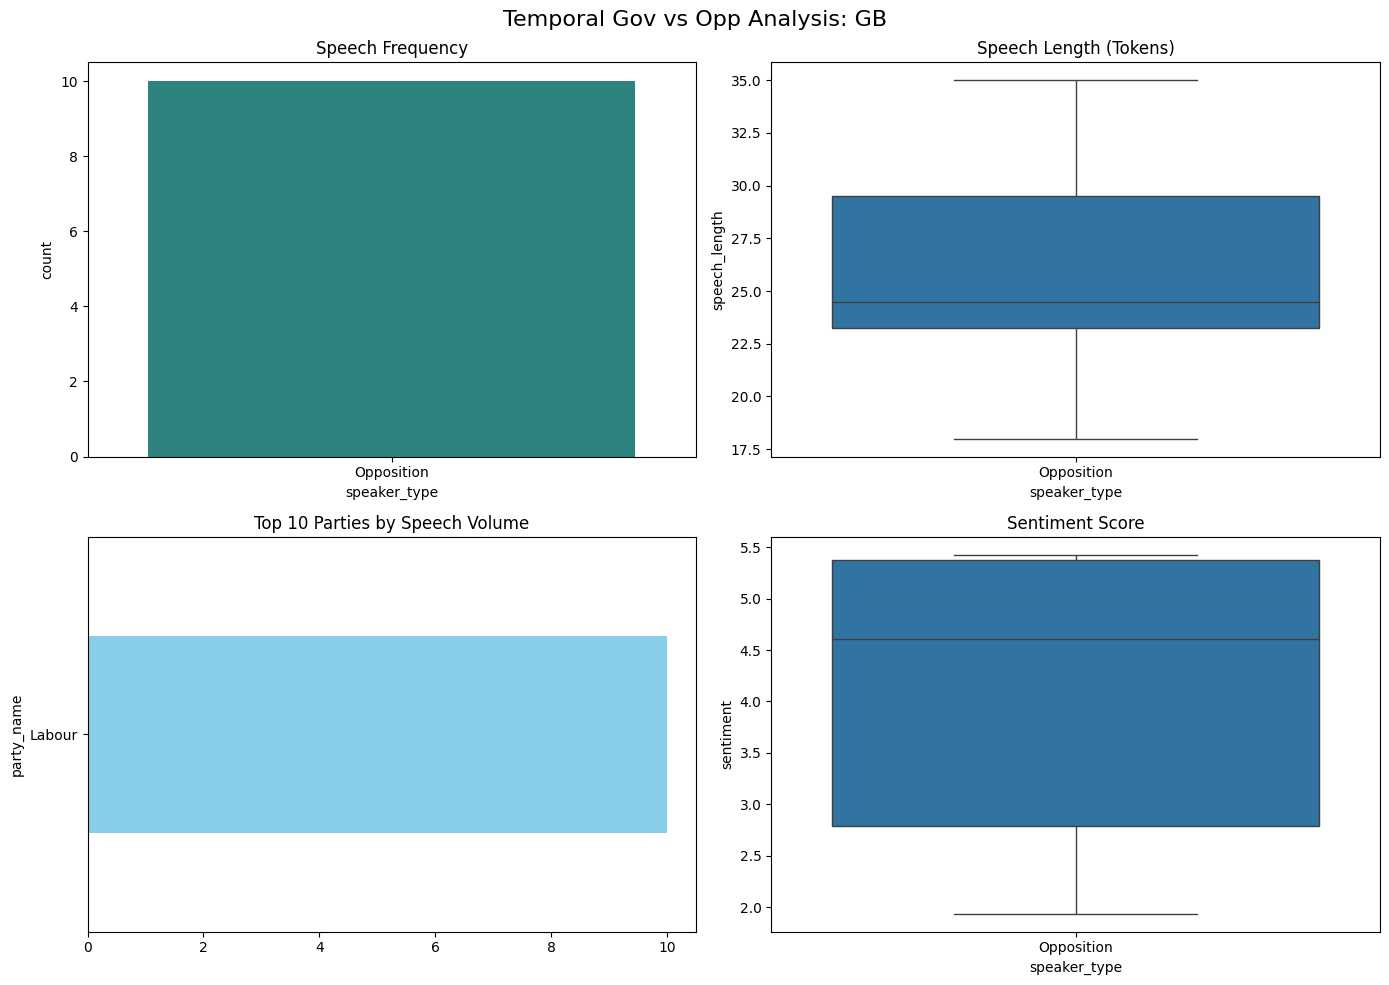


Processing GR with temporal matching...
Skipping GR: Not enough temporal matches found.
Total speeches after filtering: 3

Processing HR with temporal matching...


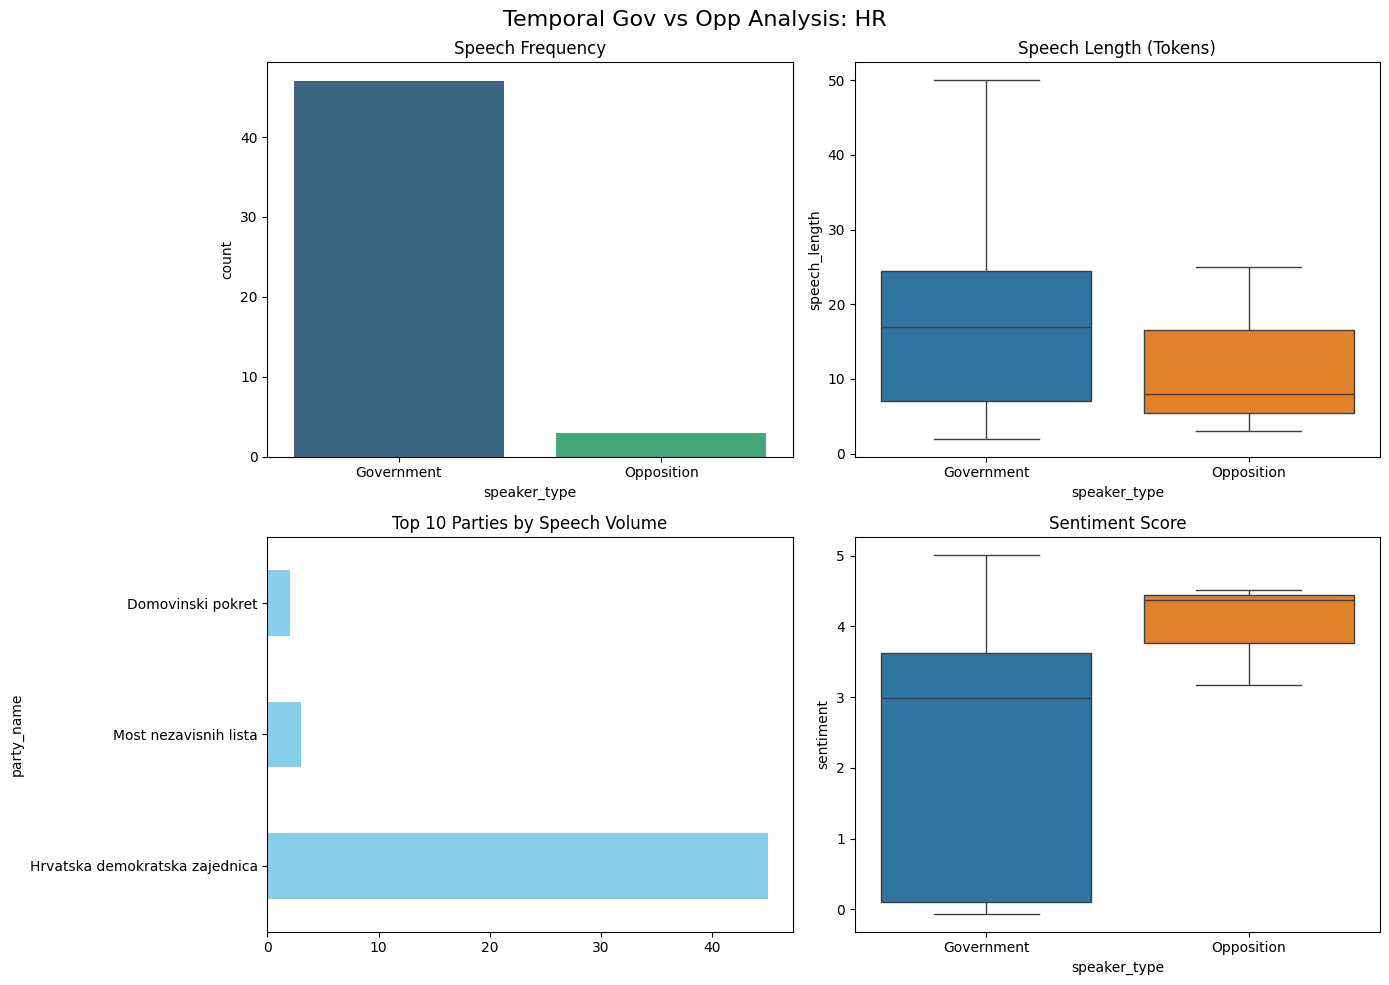


Processing HU with temporal matching...
Skipping HU: Not enough temporal matches found.
Total speeches after filtering: 0

Processing IS with temporal matching...
Skipping IS: Not enough temporal matches found.
Total speeches after filtering: 0

Processing IT with temporal matching...


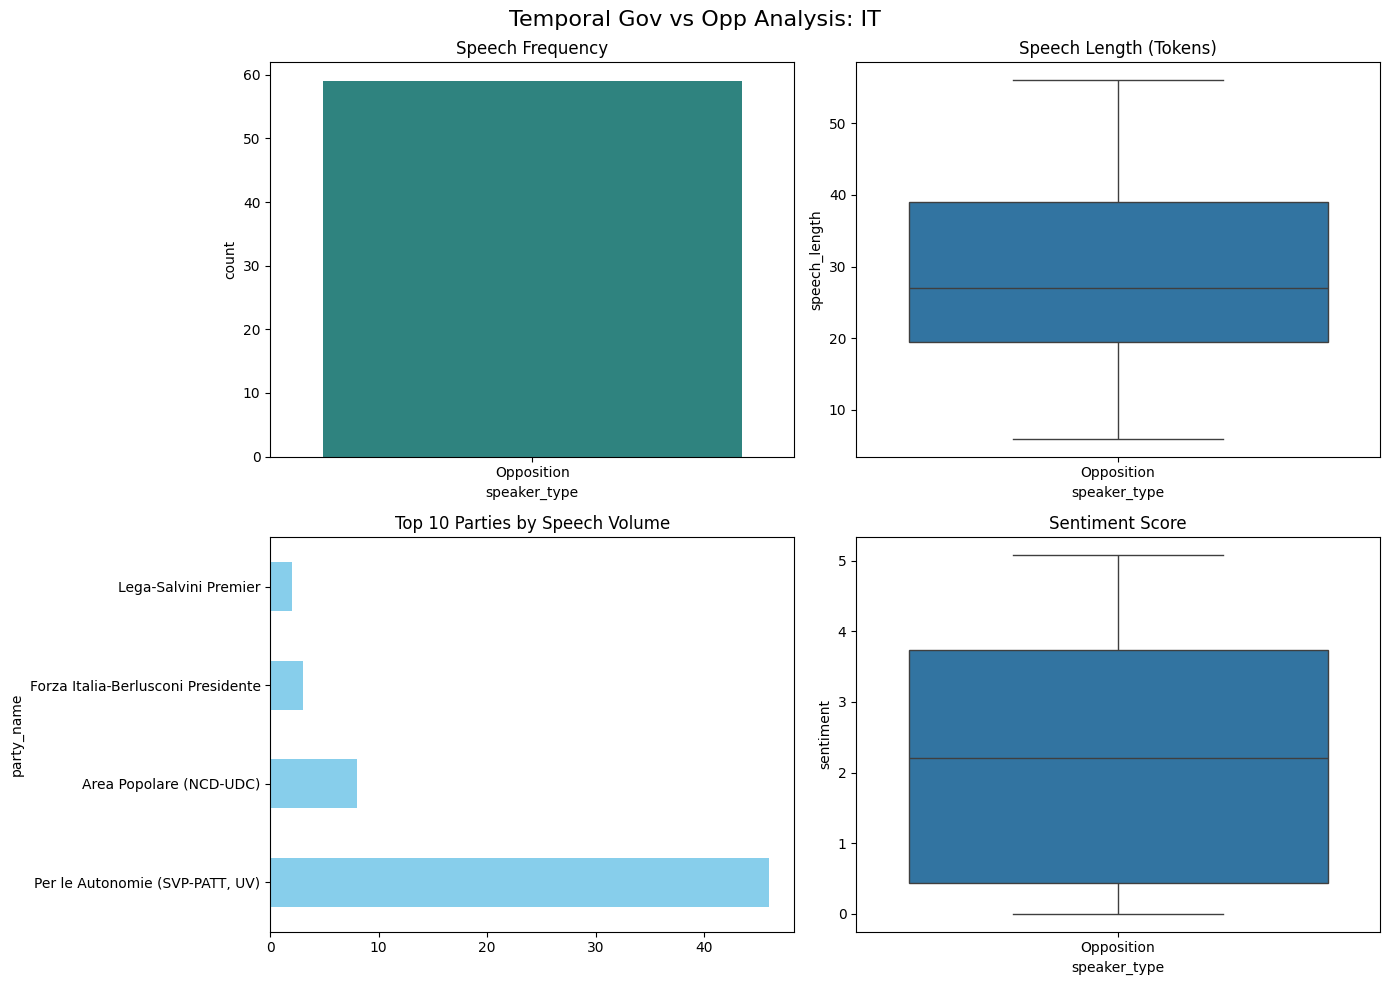


Processing LV with temporal matching...
Skipping LV: Not enough temporal matches found.
Total speeches after filtering: 0

Processing NL with temporal matching...


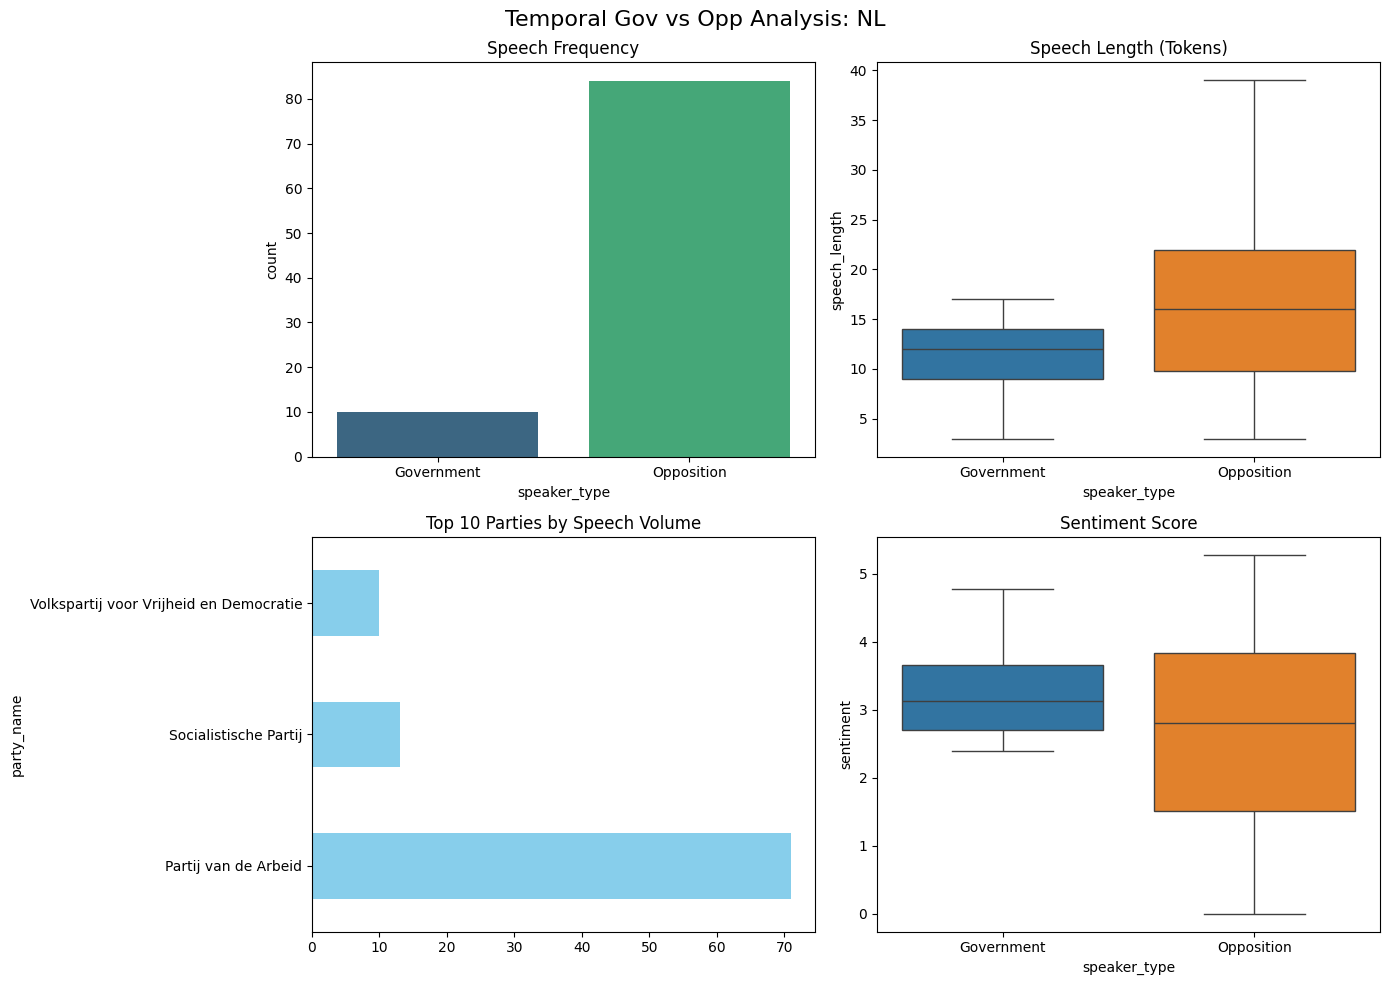


Processing NO with temporal matching...


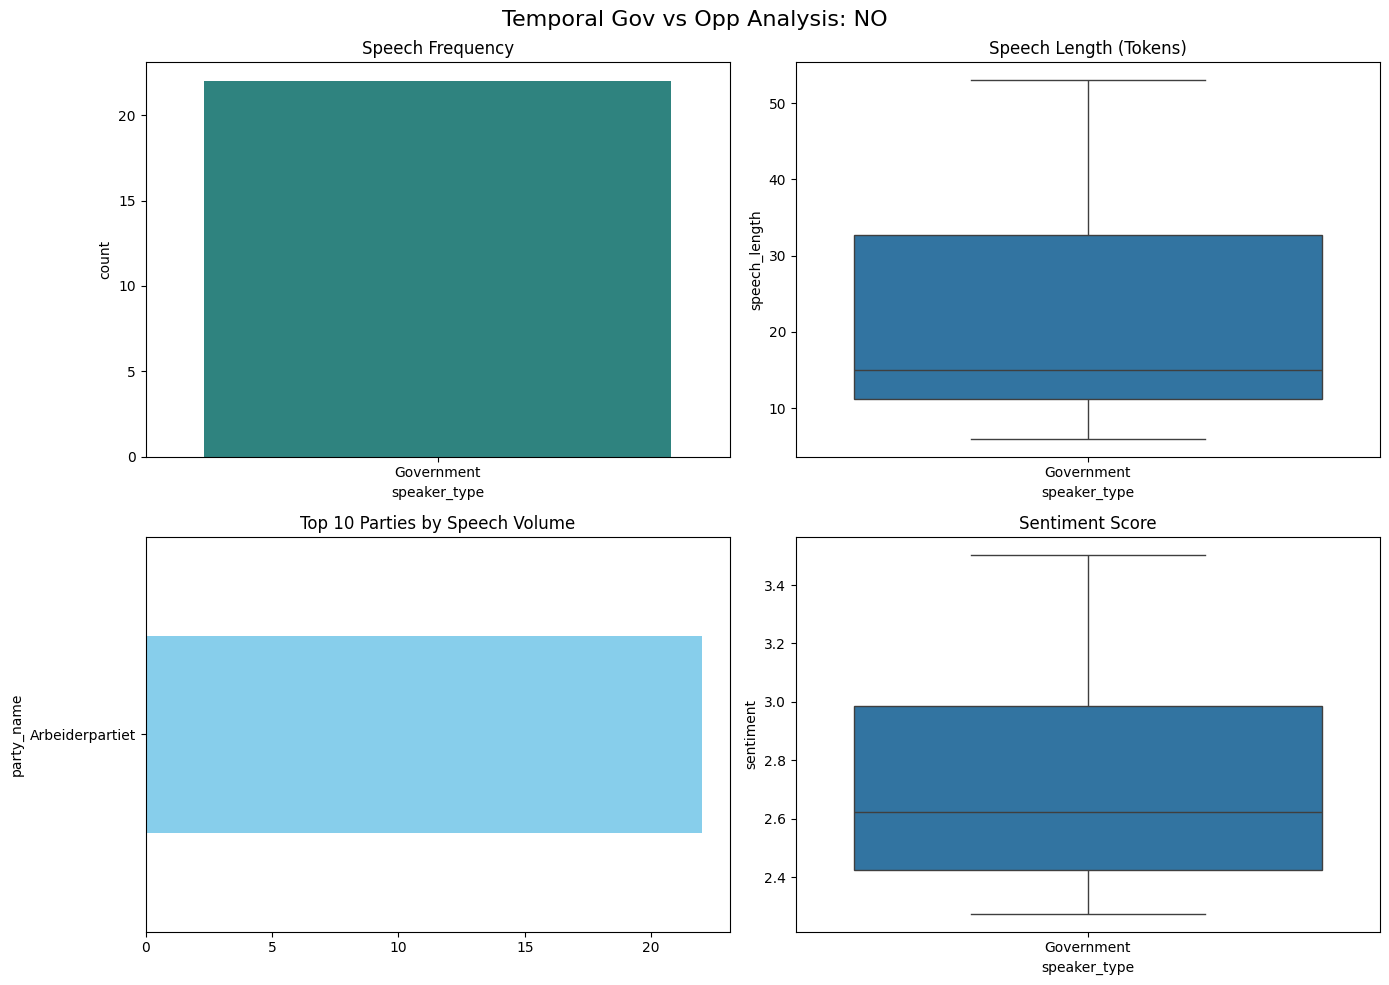


Processing PL with temporal matching...
Skipping PL: Not enough temporal matches found.
Total speeches after filtering: 0

Processing PT with temporal matching...
Skipping PT: Not enough temporal matches found.
Total speeches after filtering: 0

Processing RS with temporal matching...
Skipping RS: Not enough temporal matches found.
Total speeches after filtering: 0

Processing SE with temporal matching...


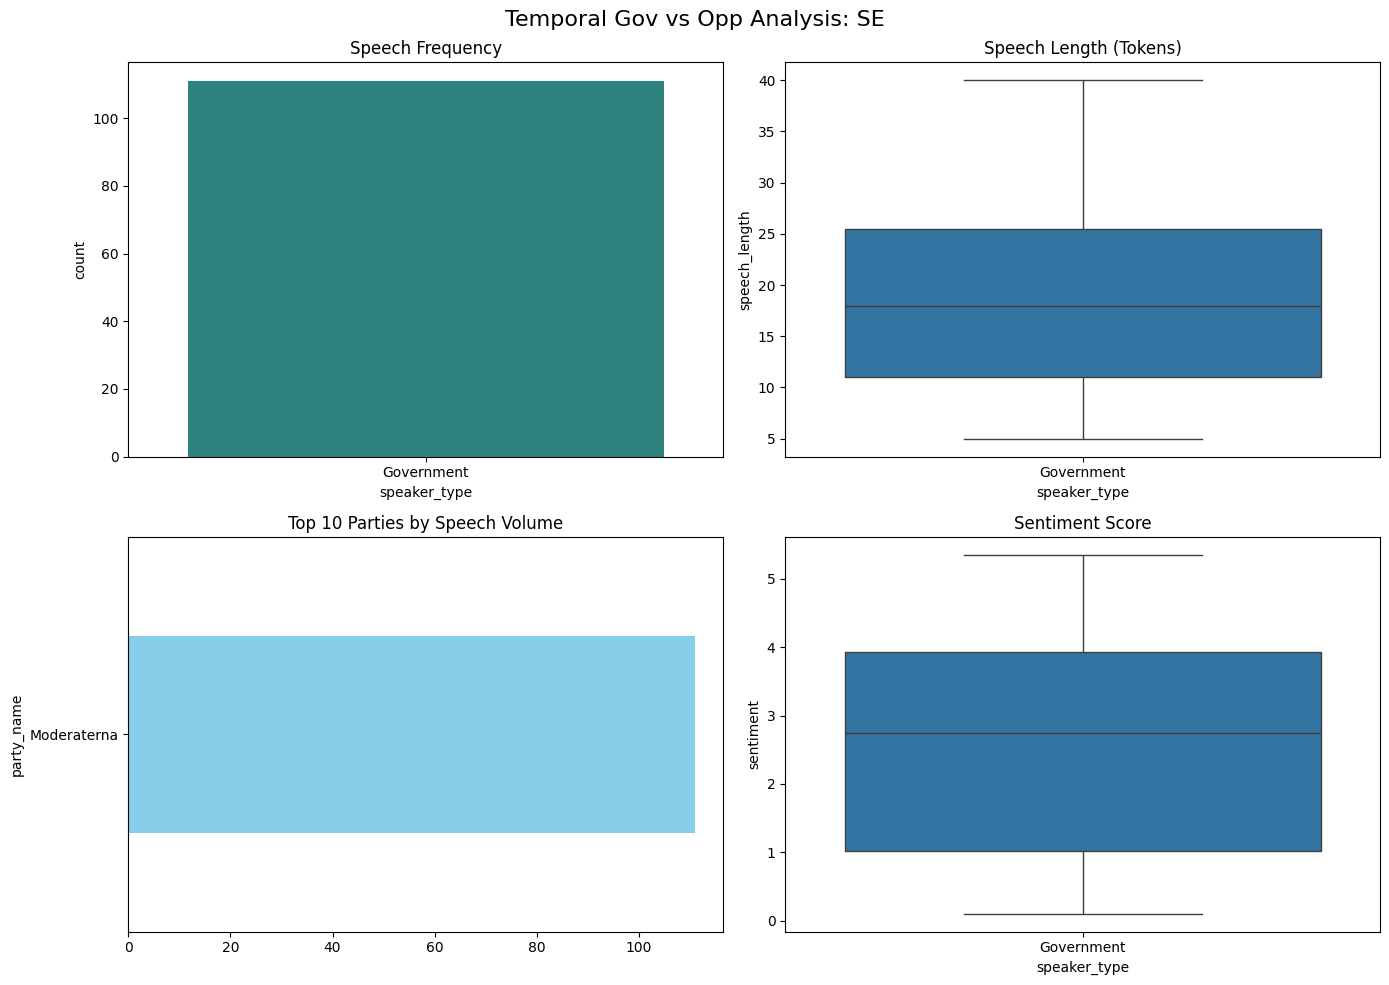


Processing SI with temporal matching...


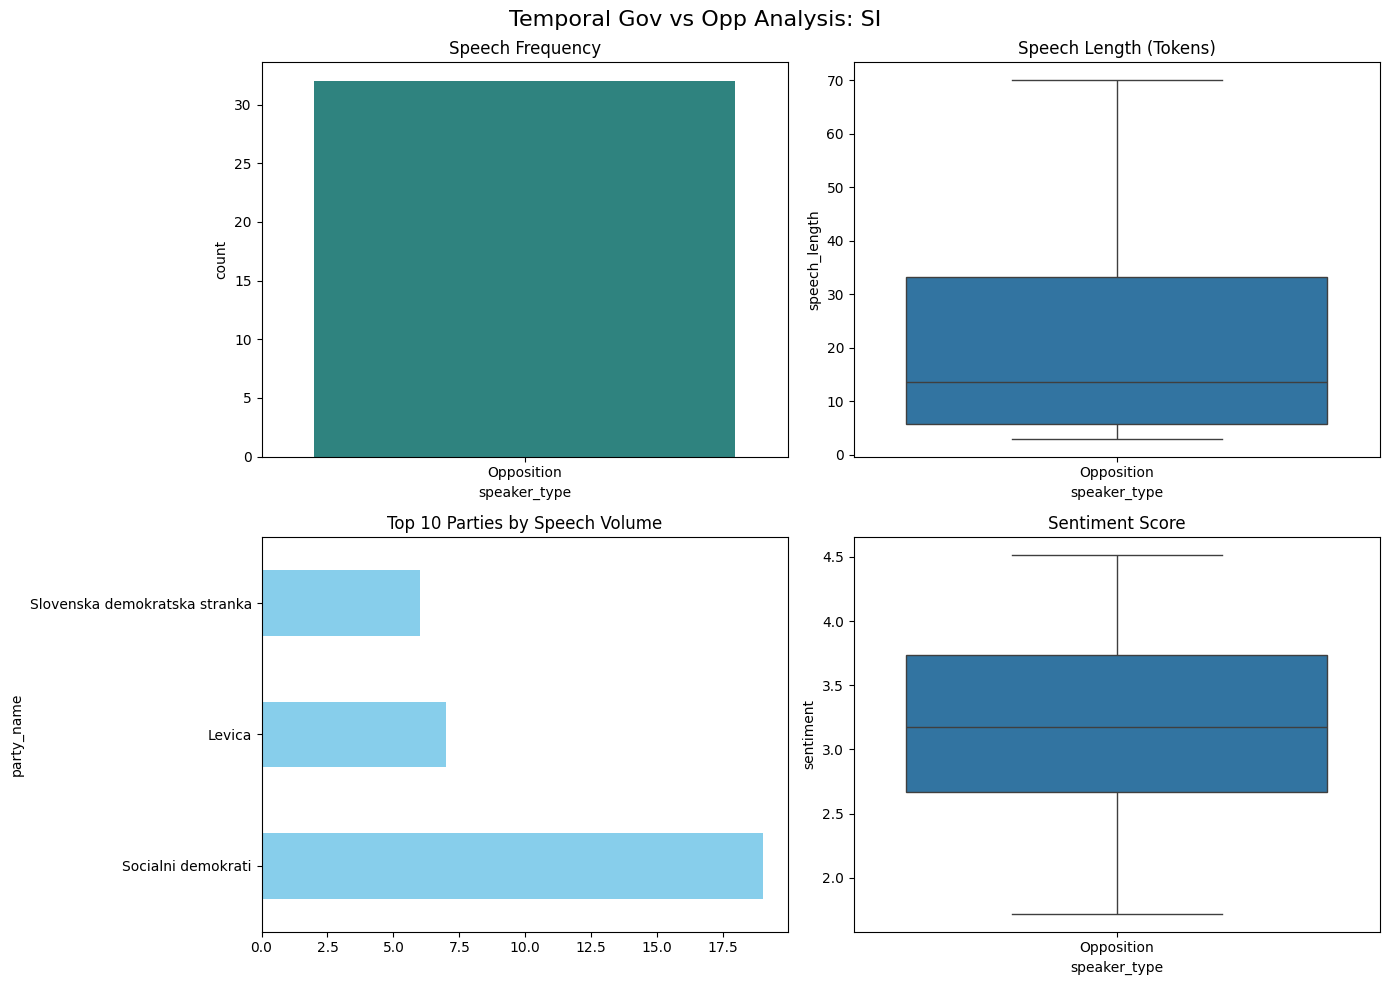


Processing TR with temporal matching...


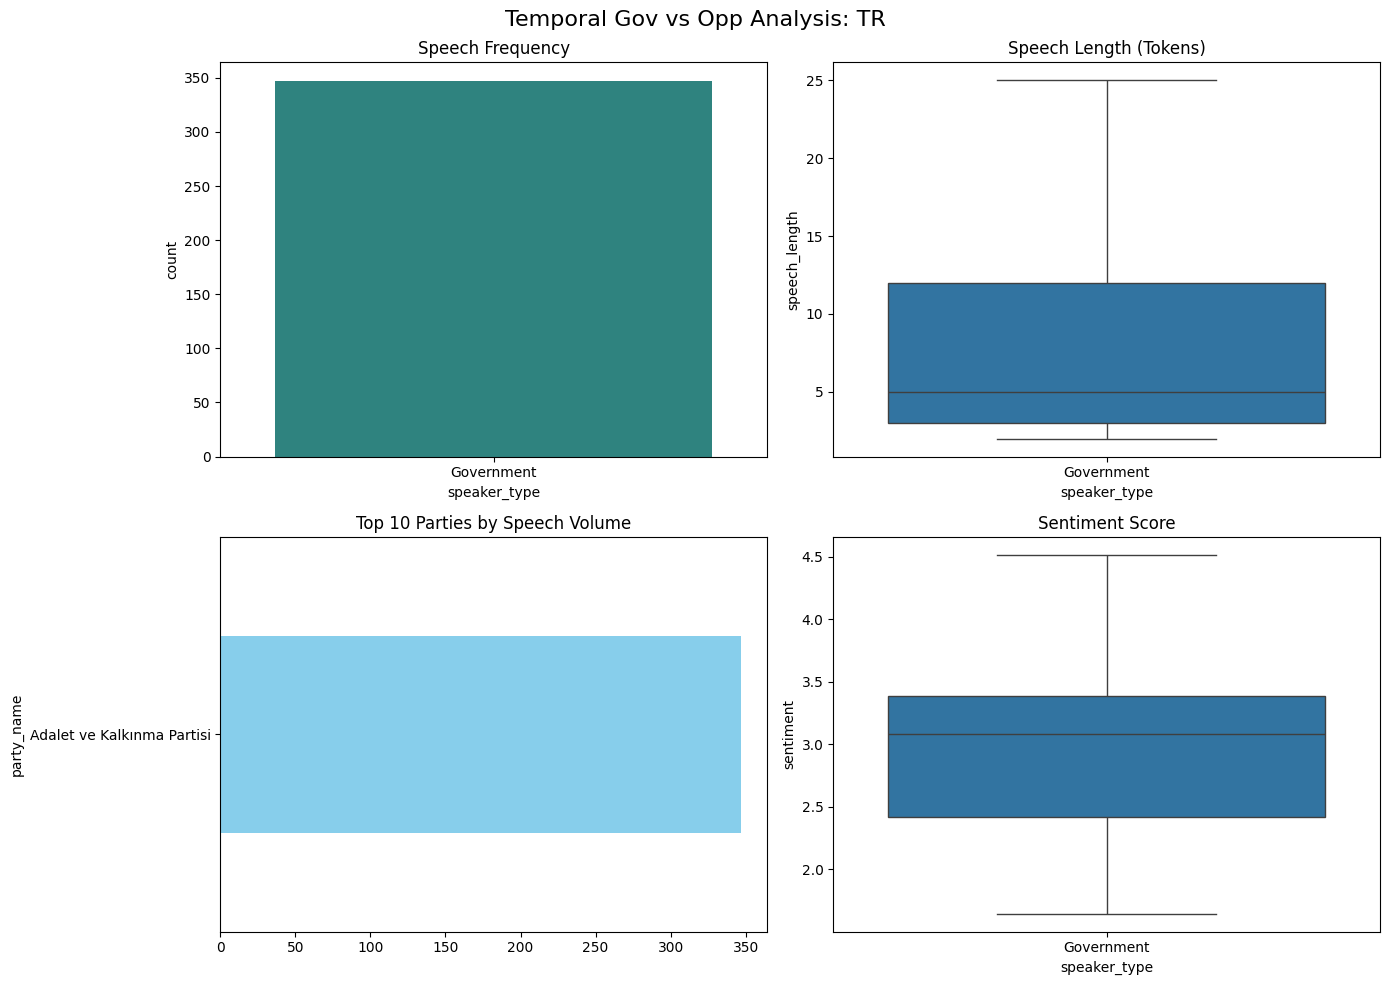


Processing UA with temporal matching...
Skipping UA: Not enough temporal matches found.
Total speeches after filtering: 0


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Temporal Relation Extractor
def get_party_status_at_time(speech_date, party_id, list_relation_nodes):
    """
    Checks if a specific party was in Coalition or Opposition on a specific date.
    """
    if party_id == 'Unknown' or not speech_date:
        return 'Other'
    
    # Standardize speech_date string for comparison
    speech_date = str(speech_date)
    
    for rel in list_relation_nodes:
        # Get date bounds for this specific relationship
        start = rel.get('from', '0001-01-01')
        end = rel.get('to', '9999-12-31')
        
        if start <= speech_date <= end:
            rel_name = rel.get('name')
            
            # Check if party is in this relation
            # 'mutual' is used for coalitions, 'active' for opposition
            members = (rel.get('mutual') or '') + ' ' + (rel.get('active') or '')
            member_ids = [m.replace('#', '').strip() for m in members.split()]
            
            if party_id in member_ids:
                return 'Government' if rel_name == 'coalition' else 'Opposition'
                
    return 'Other'

# Iterate through countries
countries = sorted([c for c in final_df['country_code'].unique() if c not in ['Unknown']])

for country_code in countries:
    country_dir = data_path / 'Samples' / f'ParlaMint-{country_code}'
    org_path = country_dir / f'ParlaMint-{country_code}-listOrg.xml'

    if not org_path.exists():
        continue

    print(f"\nProcessing {country_code} with temporal matching...")
    
    # Load the Organization tree once to get the list of relations
    org_tree = etree.parse(str(org_path))
    relation_nodes = org_tree.xpath("//tei:listRelation/tei:relation", namespaces=NS)

    # Filter data for this country
    country_data = final_df[final_df['country_code'] == country_code].copy()
    
    # This checks: "On DATE, was PARTY_ID in Govt or Opp?"
    country_data['speaker_type'] = country_data.apply(
        lambda row: get_party_status_at_time(row['date'], row['party_id'], relation_nodes), 
        axis=1
    )

    # Filter for valid comparisons
    analysis_df = country_data[country_data['speaker_type'].isin(['Government', 'Opposition'])].copy()

    if len(analysis_df) < 5:
        print(f"Skipping {country_code}: Not enough temporal matches found.")
        print(f"Total speeches after filtering: {len(analysis_df)}")
        continue

    # --- Visualization Code (Optimized for speed) ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Temporal Gov vs Opp Analysis: {country_code}', fontsize=16)

    # Plot 1: Frequency
    sns.countplot(data=analysis_df, x='speaker_type', ax=axes[0,0], palette='viridis', hue='speaker_type', legend=False)
    axes[0,0].set_title('Speech Frequency')

    # Plot 2: Speech Length (Removing outliers for clarity)
    sns.boxplot(data=analysis_df, x='speaker_type', y='speech_length', ax=axes[0,1], showfliers=False, hue='speaker_type', legend=False)
    axes[0,1].set_title('Speech Length (Tokens)')

    # Plot 3: Top Parties by Volume
    analysis_df['party_name'].value_counts().head(10).plot(kind='barh', ax=axes[1,0], color='skyblue')
    axes[1,0].set_title('Top 10 Parties by Speech Volume')

    # Plot 4: Sentiment Comparison
    sns.boxplot(data=analysis_df, x='speaker_type', y='sentiment', ax=axes[1,1], showfliers=False, hue='speaker_type', legend=False)
    axes[1,1].set_title('Sentiment Score')

    plt.tight_layout()
    plt.show()

## Sentiment & Topic Distribution
- How are sentiments distributed across your data?
- What topics are most common?
- Which speakers/parties discuss which topics?

=== GLOBAL SENTIMENT STATISTICS ===
count    5428.000000
mean        2.517144
std         1.537214
min        -0.204000
25%         1.050250
50%         2.852000
75%         3.633250
max         5.690000
Name: sentiment, dtype: float64


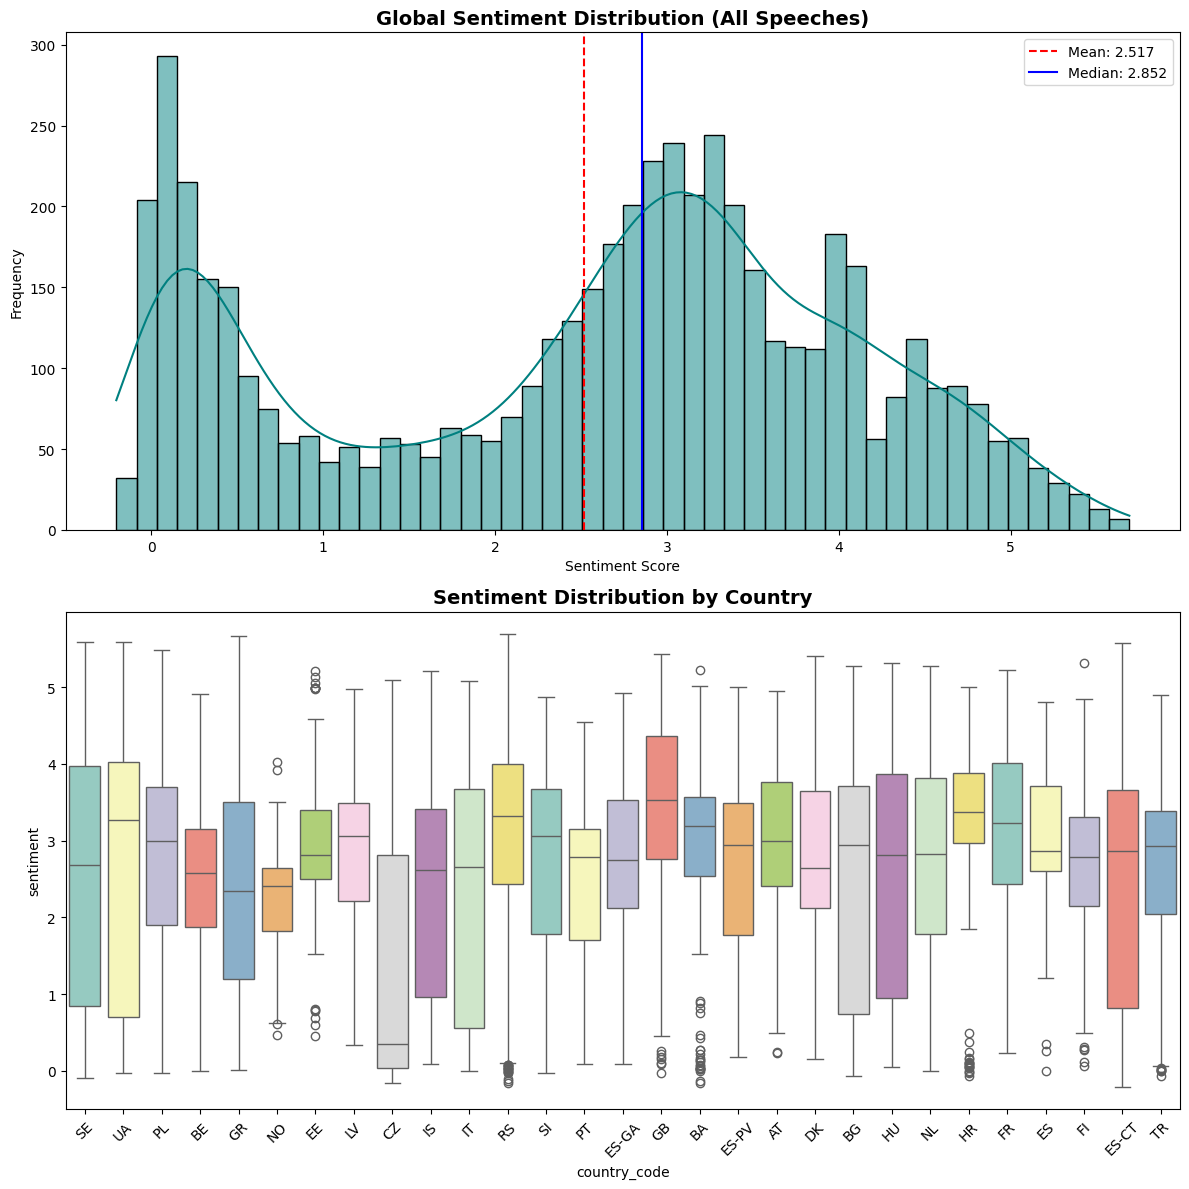


=== SAMPLES OF EXTREME SENTIMENT ===

Top 3 Most Positive Speeches:


,country_code,party_name,sentiment,text
2814,RS,Vlada Republike Srbije,5.690,With this we also want to continue and this pa...
1248,GR,Νέα Δημοκρατία,5.672,It fills us with fresh courage and makes us st...
2813,RS,Vlada Republike Srbije,5.614,We have fulfilled every promise we have made i...



Top 3 Most Negative Speeches:


,country_code,party_name,sentiment,text
4917,ES-CT,Junts pel Sí,-0.204,The permanent violation of the most elementary...
2641,RS,Narodna skupština,-0.164,"In fact, some 30,000 members of our people who..."
1931,CZ,Japonsko,-0.159,This means that you are still crushing the Cze...


In [23]:
# === Sentiment Distribution Analysis (Global) ===
# Preparation: Filter out rows without sentiment
sentiment_df = final_df.dropna(subset=['sentiment']).copy()

print("=== GLOBAL SENTIMENT STATISTICS ===")
print(sentiment_df['sentiment'].describe())

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Overall Histogram and KDE
# This shows the "shape" of the sentiment across every speech in the dataset
sns.histplot(sentiment_df['sentiment'], kde=True, ax=ax1, color='teal', bins=50)
ax1.set_title('Global Sentiment Distribution (All Speeches)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment Score')
ax1.set_ylabel('Frequency')
ax1.axvline(sentiment_df['sentiment'].mean(), color='red', linestyle='--', label=f"Mean: {sentiment_df['sentiment'].mean():.3f}")
ax1.axvline(sentiment_df['sentiment'].median(), color='blue', linestyle='-', label=f"Median: {sentiment_df['sentiment'].median():.3f}")
ax1.legend()

# Sentiment by Country if speaker_type isn't ready
sns.boxplot(data=sentiment_df, x='country_code', y='sentiment', ax=ax2, palette='Set3', hue='country_code', legend=False)
ax2.set_title('Sentiment Distribution by Country', fontsize=14, fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Most Positive vs Most Negative
print("\n=== SAMPLES OF EXTREME SENTIMENT ===")
print("\nTop 3 Most Positive Speeches:")
display(sentiment_df.nlargest(3, 'sentiment')[['country_code', 'party_name', 'sentiment', 'text']])

print("\nTop 3 Most Negative Speeches:")
display(sentiment_df.nsmallest(3, 'sentiment')[['country_code', 'party_name', 'sentiment', 'text']])

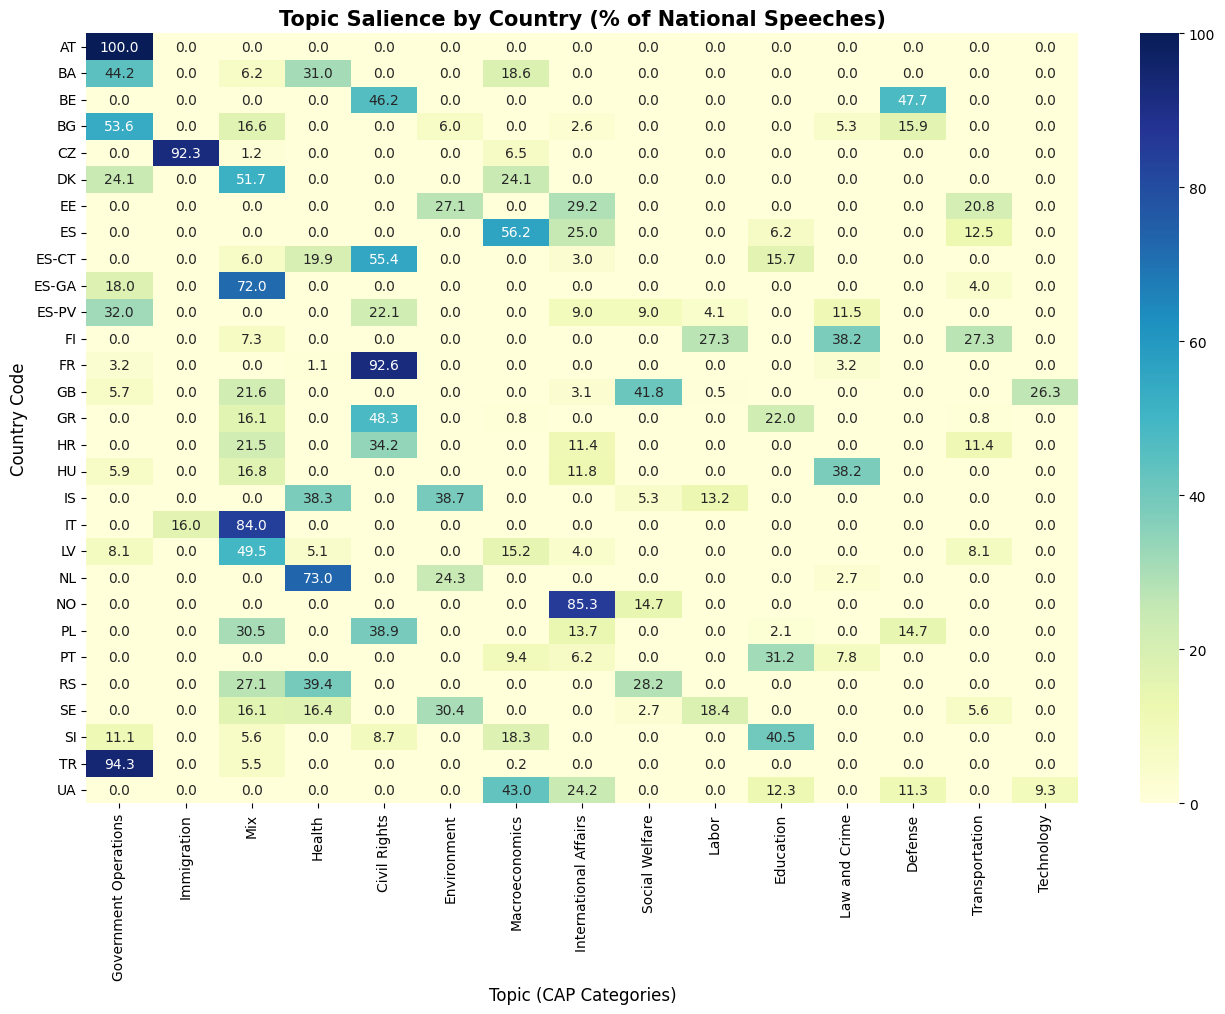

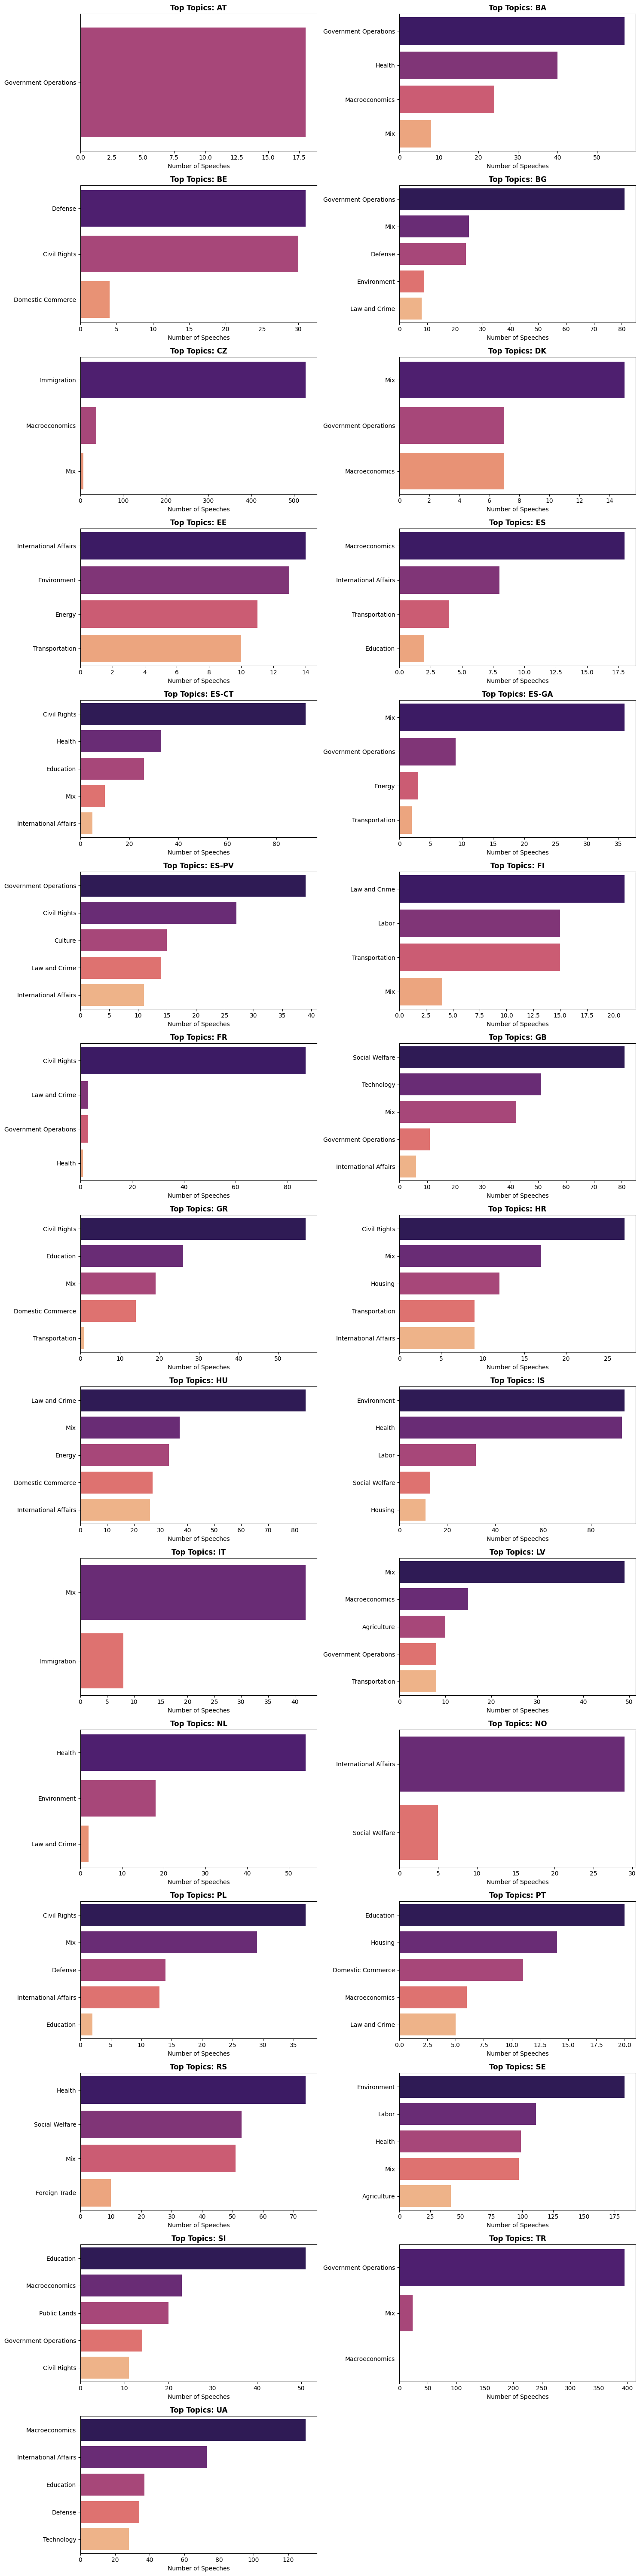

In [24]:
# Topic Analysis by Country

topics_by_country = final_df.explode('topic_labels')
topics_by_country = topics_by_country[topics_by_country['topic_labels'].notna() & 
                                     (topics_by_country['topic_labels'] != 'Other')]

# Calculate Topic Salience (Percentage of national debate)
topic_counts = topics_by_country.groupby(['country_code', 'topic_labels']).size().unstack(fill_value=0)
topic_salience = topic_counts.div(topic_counts.sum(axis=1), axis=0) * 100

# Visualization: Heatmap of National Priorities
plt.figure(figsize=(16, 10))
top_15_global_topics = topics_by_country['topic_labels'].value_counts().head(15).index
sns.heatmap(topic_salience[top_15_global_topics], annot=True, fmt=".1f", cmap="YlGnBu")

plt.title('Topic Salience by Country (% of National Speeches)', fontsize=15, fontweight='bold')
plt.xlabel('Topic (CAP Categories)', fontsize=12)
plt.ylabel('Country Code', fontsize=12)
plt.show()

# Detailed View: Top 5 Topics per Country
countries = sorted(topics_by_country['country_code'].unique())
n_countries = len(countries)
rows = (n_countries + 1) // 2  # Arrange in 2 columns

fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 4))
axes = axes.flatten()

for i, country in enumerate(countries):
    # Get top 5 topics for this specific country
    top_5 = topics_by_country[topics_by_country['country_code'] == country]['topic_labels'].value_counts().head(5)
    
    sns.barplot(x=top_5.values, y=top_5.index, ax=axes[i], palette='magma', hue=top_5.index, legend=False)
    axes[i].set_title(f'Top Topics: {country}', fontweight='bold')
    axes[i].set_xlabel('Number of Speeches')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Data Quality Checks 
- Missing values in key columns
- Speaker/organization coverage gaps
- Date/time consistency